### Multi Class Classification
In multi-class classification we have K classes, so the dataset becomes:
$$
D = \{(x_i,y_i) | \quad i\in\{1,...,N\}, \quad x_i \in R^D, \quad  y_i \in\{1,...,K\}\}
$$
We want our model to approximate the true distribution $p(y|x)$ with the parametric distribution:
$$
p_{model}(y_i|x;\Theta) = \begin{cases}
p_1 \quad \text{if}\quad y_i = 1 \\
...\\
p_K\quad \text{if}\quad y_i = K
\end{cases} \quad \text{with} \quad p_i = f_i(x;\Theta)
$$
Then we classify new instances assigning a sample to the class with greatest probability
$$
x \in C_k \quad \text{if}\quad  p_k > p_j \quad \forall j \ne k
$$
Again we want to choose a function $f(x_i,\Theta)$ that is linear with respect to the parameters. To do this we need K linear functions such that the binary classification between $C_j$ and $C_k$ can be formulated as a linear function of the parameters. In particular, if we define:
$$
p_i = f_i(x,\theta) = \frac{e^{\mathbf{w_i}^T \mathbf{x}}}{\sum_{h=1}^K e^{\mathbf{w_h}^T \mathbf{x}}}
$$
In this way  we obtain:
$$
p_k > p_j
$$
$$
\frac{e^{\mathbf{w_k}^T \mathbf{x}}}{\sum_{h=1}^K e^{\mathbf{w_h}^T \mathbf{x}}} > \frac{e^{\mathbf{w_j}^T \mathbf{x}}}{\sum_{h=1}^K e^{\mathbf{w_h}^T \mathbf{x}}}
$$
$$
e^{\mathbf{w_k}^T \mathbf{x}} > e^{\mathbf{w_j}^T \mathbf{x}}
$$
$$
\mathbf{w_k}^T \mathbf{x} > \mathbf{w_j}^T \mathbf{x}
$$
Hence the decision surface between classes k and j is
$$
\mathbf{w_k}^T \mathbf{x} = \mathbf{w_j}^T \mathbf{x} \rightarrow (\mathbf{w_k}^T - \mathbf{w_j}^T) \mathbf{x} = 0
$$

To ease the notation we can represent the labels using a one-hot-encoding, i.e. the label for $x_i$ is a vector $y_i$ with K entries, where the all entries are zero with the exception of the entry that corresponds to the label of x:
For example for a 3 classes classification problem
$$
x_i \in C_1 \rightarrow y_i = \begin{pmatrix}1 \\ 0 \\ 0\end{pmatrix}
$$
$$
x_i \in C_2 \rightarrow y_i = \begin{pmatrix}0 \\ 1 \\ 0\end{pmatrix}
$$
$$
x_i \in C_3 \rightarrow y_i = \begin{pmatrix}0 \\ 0 \\ 1\end{pmatrix}
$$
With this notation we can write the loss function as:
$$
L(w_1,...,w_k) = - \sum_{i=1}^N \sum_{j=1}^K y_i[j] log(p_i[j])
$$
where
$$
p_i[j] = \frac{e^{\mathbf{w_j}^T \mathbf{x_i}}}{\sum_{h=1}^K e^{\mathbf{w_h}^T \mathbf{x_i}}}
$$
If we compute the gradient of L with respect to the __vector__ $\mathbf{w_j}$ we obtain:
$$
\nabla_j L = \sum_{i=1}^N (y_i[j]-p_i[j])\mathbf{x_i}
$$
So this time we have k vectors of parameters $\mathbf{w_j}$ and a gradient vector for each of those vectors.
Again we update each vector with gradient descent.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N = 300
K = 3
m1 = [1.,2.5]
m2 = [3.,1.5]
m3 = [1.,1.]
cov = np.asarray([[.4, .5],
        [.5, .01]])
cov = cov @ np.transpose(cov)
X_1 = np.random.multivariate_normal(mean=m1,cov=cov,size=N//3)
X_2 = np.random.multivariate_normal(mean=m2,cov=cov,size=N//3)
X_3 = np.random.multivariate_normal(mean=m3,cov=cov,size=N//3)

X_1.shape

(100, 2)

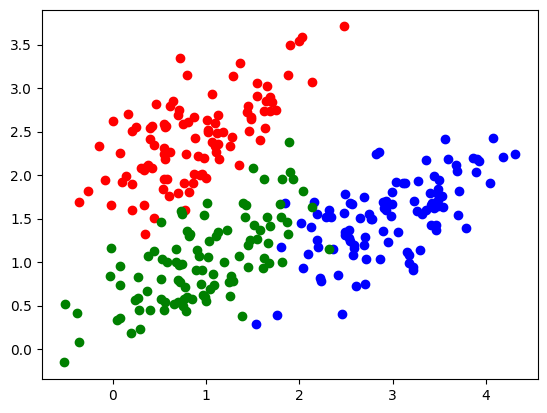

In [3]:
fig,ax = plt.subplots()
ax.scatter(x=X_1[:,0],y=X_1[:,1],c="r")
ax.scatter(x=X_2[:,0],y=X_2[:,1],c="b")
ax.scatter(x=X_3[:,0],y=X_3[:,1],c="g")
plt.show()

In [4]:
w1 = np.random.normal(size=3)
w2 = np.random.normal(size=3)
w3 = np.random.normal(size=3)
W = np.stack([w1,w2,w3],axis=0)
W.shape

(3, 3)

In [5]:
X = np.concatenate([X_1,X_2,X_3],axis=0)
X = np.concatenate([
    np.ones(shape=(X.shape[0],1)),
    X
],axis=1)
X.shape

(300, 3)

In [6]:
labels = np.concatenate([
    np.zeros(shape=X_1.shape[0],dtype=np.int32),
    np.ones(shape=X_2.shape[0],dtype=np.int32),
    2*np.ones(shape=X_3.shape[0],dtype=np.int32)
],axis=0)
y_true = np.zeros((labels.shape[0],3))
y_true[np.arange(labels.shape[0]),labels] = 1
y_true.shape

(300, 3)

In [7]:
def pred(X,W):
    y_1 = X @ W[0,:]
    y_2 = X @ W[1,:]
    y_3 = X @ W[2,:]
    p_1 = np.exp(y_1) / (np.exp(y_1)+np.exp(y_2)+np.exp(y_3))
    p_2 = np.exp(y_2) / (np.exp(y_1)+np.exp(y_2)+np.exp(y_3))
    p_3 = np.exp(y_3) / (np.exp(y_1)+np.exp(y_2)+np.exp(y_3))
    p = np.stack([p_1,p_2,p_3],-1)
    return p

In [8]:
def gradient(X,W,Y):
    P = pred(X,W)
    o = Y-P
    g1 = -np.sum(o[:,0,None] * X,axis=0)
    g2 = -np.sum(o[:,1,None] * X,axis=0)
    g3 = -np.sum(o[:,2,None] * X,axis=0)
    return np.stack([g1,g2,g3],axis=0)

In [9]:
eps = 10**-1
eta = 10**-1
W_old = np.zeros_like(W)
W_new = W
step = 0

In [10]:
x_max = max(X[:,1])
x_min = min(X[:,1])
x = np.arange(x_min,x_max,0.5)
x.shape

(10,)

In [11]:
def dec_surface(x,w):
    m = -w[1]/w[2]
    q = -w[0]/w[2]
    y = m*x+q
    return y

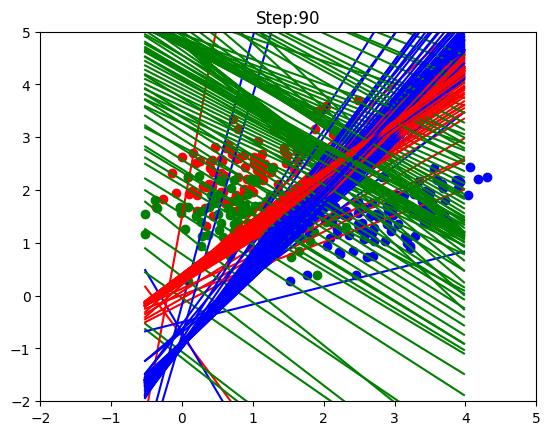

In [12]:
MAX_STEPS = 200
fig,ax = plt.subplots()
ax.set_xlim([-2, 5])
ax.set_ylim([-2, 5])
ax.scatter(x=X_1[:,0],y=X_1[:,1],c="r")
ax.scatter(x=X_2[:,0],y=X_2[:,1],c="b")
ax.scatter(x=X_3[:,0],y=X_2[:,1],c="g")
while np.linalg.norm(W_old[0,:]-W_new[0,:]) > eps and \
        np.linalg.norm(W_old[1,:]-W_new[1,:]) and \
        np.linalg.norm(W_old[2,:]-W_new[2,:]) and \
        step < MAX_STEPS:
    W_old = W_new
    grad = gradient(X,W_old,y_true)
    W_new = W_old - eta*grad
    step +=1
    ax.plot(x,dec_surface(x,W_new[0]),c="r")
    ax.plot(x,dec_surface(x,W_new[1]),c="b")
    ax.plot(x,dec_surface(x,W_new[2]),c="g")
    ax.set_title(f"Step:{step}")
    fig.canvas.draw()
plt.show()

Now let's plot the decision surfaces. Remember that a sample x is assigned to class $C_j$ if $p_j > p_i$ for every $i\ne j$. That is the same as $w_j^Tx > w_i^Tx$ for every $i\ne j$. Geometrically, this means that a point x is assigned to the class such that the signed distance between the point and the decision surface is maximized.

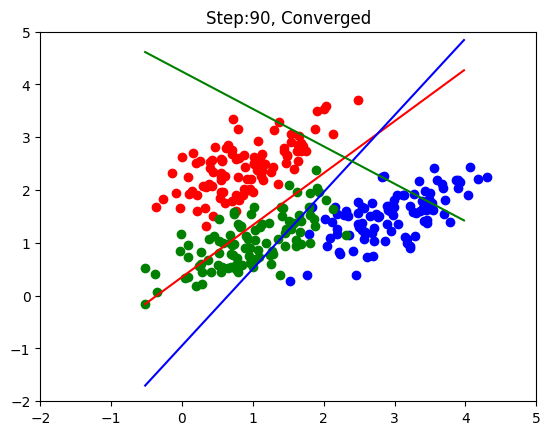

In [13]:
fig,ax = plt.subplots()
ax.set_xlim([-2, 5])
ax.set_ylim([-2, 5])
ax.scatter(x=X_1[:,0],y=X_1[:,1],c="r")
ax.scatter(x=X_2[:,0],y=X_2[:,1],c="b")
ax.scatter(x=X_3[:,0],y=X_3[:,1],c="g")
ax.plot(x,dec_surface(x,W_new[0]),c="r")
ax.plot(x,dec_surface(x,W_new[1]),c="b")
ax.plot(x,dec_surface(x,W_new[2]),c="g")
if step < MAX_STEPS:
    ax.set_title(f"Step:{step}, Converged")
else:
    ax.set_title(f"Step:{step}, Max Iter")
plt.show()

We can plot the decision boundaries for each pair of classes. Remember that the decision boundary between class $C_i$ and class $C_j$ is the line with equation:
$$
(\mathbf{w_i}^T - \mathbf{w_j}^T)\mathbf{x} = 0
$$

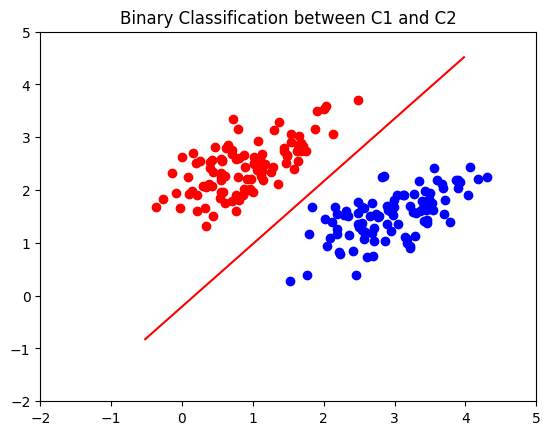

In [14]:
fig,ax = plt.subplots()
ax.set_xlim([-2, 5])
ax.set_ylim([-2, 5])
ax.scatter(x=X_1[:,0],y=X_1[:,1],c="r")
ax.scatter(x=X_2[:,0],y=X_2[:,1],c="b")
ax.plot(x,dec_surface(x,W_new[0]-W_new[1]),c="r")

ax.set_title(f"Binary Classification between C1 and C2")
plt.show()

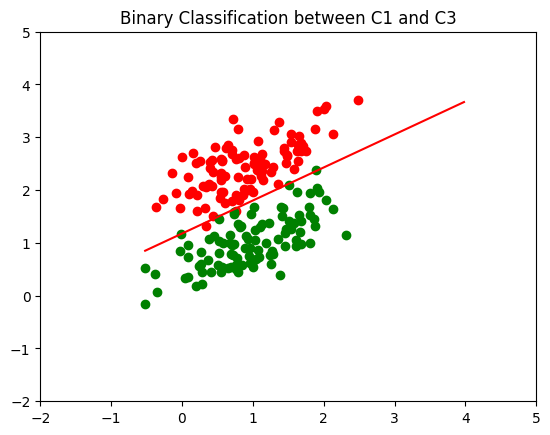

In [15]:
fig,ax = plt.subplots()
ax.set_xlim([-2, 5])
ax.set_ylim([-2, 5])
ax.scatter(x=X_1[:,0],y=X_1[:,1],c="r")
ax.scatter(x=X_3[:,0],y=X_3[:,1],c="g")
ax.plot(x,dec_surface(x,W_new[0]-W_new[2]),c="r")

ax.set_title(f"Binary Classification between C1 and C3")
plt.show()

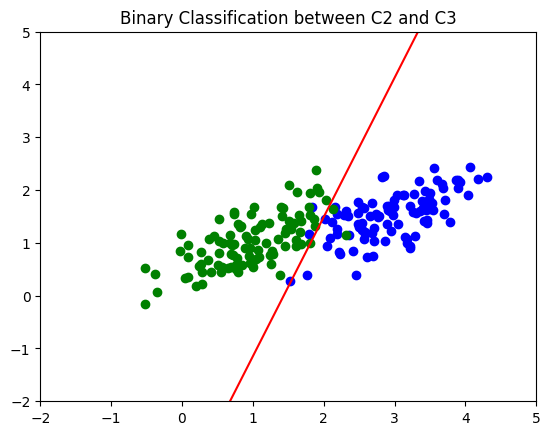

In [16]:
fig,ax = plt.subplots()
ax.set_xlim([-2, 5])
ax.set_ylim([-2, 5])
ax.scatter(x=X_2[:,0],y=X_2[:,1],c="b")
ax.scatter(x=X_3[:,0],y=X_3[:,1],c="g")
ax.plot(x,dec_surface(x,W_new[1]-W_new[2]),c="r")

ax.set_title(f"Binary Classification between C2 and C3")
plt.show()